# Six Degrees of Kevin Bacon

![kevin](Kevin_Bacon.jpg)


1994.godine glumac Kevin Bacon je u intervjuu izjavio da je radio sa svakim glumcem u Hollywoodu ili s nekim tko je s njime radio.

Temeljem toga inspirirana je igra koja svakom glumcu pridružuje *Bacon*-ov broj koji govori koliko je osoba udaljena od Kevina Bacona s obzirom na osobe s kojima je surađivala na filmovima.
* Kevin Bacon ima Baconov broj 0
* Osoba koja je direktno surađivala s njime 1
* Ako je najmanji Baconov broj od svih osoba s kojima je neka osoba surađivala N onda je njen Baconov broj N+1

Npr. Ian McKellen je glumio u *X-Men:Days of Future Past(2014)* s Michaelom Fassbenderom i Jamesom McAvoyem, a McAvoy i Fassbender su glumili s Baconom u *X-Men: First Class (2011)*. Stoga McAvoy i Fassbender imaju Baconov broj 1 dok McKellen ima Baconov broj 2.

Naziv igre je inspiriran s [6 stupnjeva separacije](https://en.wikipedia.org/wiki/Six_degrees_of_separation) ili pravilom 6 rukovanja koje kaže da su bilo koja dva čovjeka udaljena poznanstvima u najviše šest koraka. Kevin Bacon je 2007. godine osnovao dobrotvornu udrugu [SixDegrees.org](https://en.wikipedia.org/wiki/SixDegrees.org).


Da bi se zabavili ovim problemom najjednostavnije je da prikažimo glumce kao vrhove u grafu gdje povezanost bridom znači da su dva glumca glumila zajedno u nekom filmu. Npr.

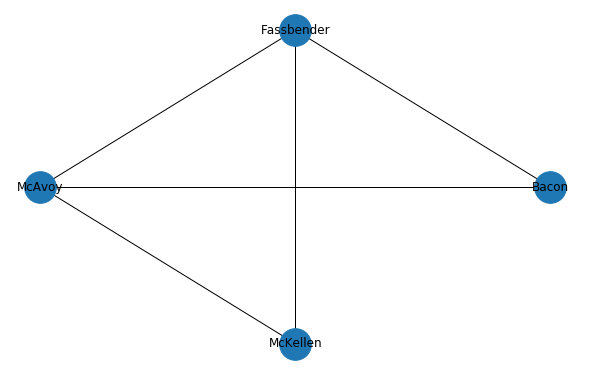

In [87]:
import networkx as nx
import matplotlib.pyplot as plt

g=nx.Graph()
g.add_edge('Bacon','Fassbender')
g.add_edge('Bacon','McAvoy') 
g.add_edge('Fassbender','McAvoy')
g.add_edge('Fassbender','McKellen')
g.add_edge('McAvoy','McKellen')

pos = nx.circular_layout(g)
plt.figure(figsize=(8,5))
nx.draw(g, pos, node_size=1000, with_labels=True)
plt.show()

## Implementacija

Odredimo Baconove brojeve na skupu od 9235 glumaca i 7067 filmova. Podatke sam preuzeo za sljedeće [stranice](https://www.cs.dartmouth.edu/~cbk/classes/10/14winter/hws.php?hw=PS-5). U datoteci `bacon.zip` nalaze se tekstualne datoteke `actors.txt` u kojoj su redci oblika: **id_glumca | ime_glumca**, `movies.txt` u kojoj su redci oblika **id_filma | ime_filma(godina)** te `movie-actors.txt` u kojoj su redci oblika **id_filma | id_glumca** što označava da je glumac s brojem **id_glumca** glumio u filmu s brojem **id_filma**.

Najprije izvucimo te podatke u rječnike **id_movies** u kojem su ključevi id filmova a vrijednosti imena filmova, **id_actors** gdje su ključevi id glumaca a vrijednosti imena glumaca (**actors_id** je isto samo što su zamijenjeni ključevi i vrijednosti) te **movies_actors** koji glumcu s nekim id-om pridužuje id-eve svih filmova u kojima je glumio i obratno **actors_movies** koji id-u filma pridružuje id-eve svih glumaca iz datoteke koji su glumili u tom filmu.

In [88]:
def to_pair(line):
    key, value=line.rstrip('\n').split('|')
    return value,int(key)

def to_pair1(line):
    key, value=line.rstrip('\n').split('|')
    return int(key),value

def to_pair2(line):
    key, value=line.rstrip('\n').split('|')
    return int(key),int(value)

with open('movies.txt','r',encoding="utf8") as f:
    id_movies=dict(map(to_pair1,f))

with open('actors.txt','r',encoding="utf8") as f:
    id_actors=dict(map(to_pair1,f))

with open('actors.txt','r',encoding="utf8") as f:
    actors_id=dict(map(to_pair,f))

In [89]:
from collections import defaultdict 
movies_actors=defaultdict(list)
actors_movies=defaultdict(list)
with open('movie-actors.txt','r') as f:
    for line in f:
        pair=to_pair2(line)
        movies_actors[pair[0]].append(pair[1])
        actors_movies[pair[1]].append(pair[0])   

Sada možemo napraviti rječnik incidencije koji id-u svakog glumca pridružuje listu id-eva glumaca s kojima je glumio u nekom filmu.

In [90]:
actor_adj=defaultdict(list)
for actor1 in id_actors.keys():
    for movie in actors_movies[actor1]:
        for actor2 in movies_actors[movie]:
            if actor2!=actor1:
                actor_adj[actor1].append(actor2)

Od rječnika incidencije kreiramo graf koji ćemo nazvati **suradnje**:

In [91]:
import networkx as nx
suradnje=nx.Graph()
for actor,lista in actor_adj.items():
    for actor2 in lista:
        suradnje.add_edge(actor,actor2)

## BFS (Breadth-First Search)

Baconove brojeve ćemo tražiti koristeći BFS algoritam pretraživanja u širinu.

BFS krečući iz nekog vrha pretražuje najprije njegove susjede a zatim ide na sljedeću dubinu gdje pretražuje susjede susjeda itd.

Sljedeća funkcija **bfs(graf,start)** za *graf* vraća sve vrhove dostupne iz vrha *start*.

In [92]:
import queue
               
def bfs(graf, start):
    dostizni=set()
    q=queue.Queue()
    q.put(start)
    
    while not q.empty():
        trenutni = q.get()
        if trenutni not in dostizni:
            dostizni.add(trenutni)
            for susjed in graf[trenutni]:
                q.put(susjed)
    return dostizni


Ako krećemo iz nekog fiksnog vrha i tražimo put to nekog drugog vrha jasno je da ćemo ovakvim načinom pretraživanja stvarno naći najkraći put između ta dva vrha jer da to nije najkraći put onda bi na traženi vrh naišli kao susjeda na nižoj dubini.

Funkcija **bfs_put(graf,start,kraj)** krečući od vrha *start* u *grafu* nalazi najkraći put do vrha *kraj* i vraća ga kao listu.

In [93]:
def bfs_put(graf, start, kraj):
    visit_queue = queue.Queue()
    visit_queue.put([start])
    marked= set([start])

    while not visit_queue.empty():
        visited = visit_queue.get()
        trenutni= visited[-1]
        if trenutni == kraj:
            return visited
        for susjed in graf[trenutni]:
            if susjed not in marked:
                marked.add(susjed)
                visit_queue.put(visited + [susjed])

Pogledajmo na primjeru što vraćaju ove dvije funkcije.

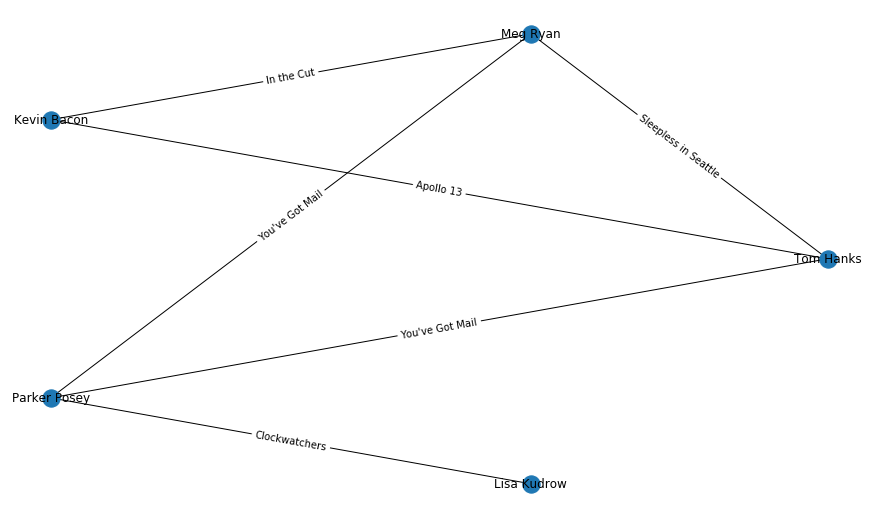

In [94]:
plt.rcParams['figure.figsize'] = [12,7]
g=nx.Graph()
g.add_edges_from([('Tom Hanks','Meg Ryan'),('Meg Ryan','Kevin Bacon'),('Kevin Bacon','Tom Hanks'),
                  ('Meg Ryan','Parker Posey'),('Parker Posey','Lisa Kudrow'),('Tom Hanks','Parker Posey')])
pos=nx.circular_layout(g)
nx.draw(g,pos,with_labels=True)
labels={('Tom Hanks','Meg Ryan'):'Sleepless in Seattle',('Meg Ryan','Kevin Bacon'):'In the Cut',
        ('Kevin Bacon','Tom Hanks'):'Apollo 13',('Meg Ryan','Parker Posey'):'You\'ve Got Mail',
        ('Parker Posey','Lisa Kudrow'):'Clockwatchers',('Tom Hanks','Parker Posey'):'You\'ve Got Mail'}
nx.draw_networkx_edge_labels(g,pos,edge_labels=labels)
plt.show()

Jer je graf povezan vidimo da su svi povezani s Kevinom Baconom.

In [95]:
bfs(g,'Kevin Bacon')

{'Kevin Bacon', 'Lisa Kudrow', 'Meg Ryan', 'Parker Posey', 'Tom Hanks'}

Sada za svakog ispišimo put do Kevina Bacona.

In [96]:
for actor in g.nodes():
    put=' <--> '.join(bfs_put(g,actor,'Kevin Bacon'))
    print(f'{actor}: {put}')

Tom Hanks: Tom Hanks <--> Kevin Bacon
Meg Ryan: Meg Ryan <--> Kevin Bacon
Kevin Bacon: Kevin Bacon
Parker Posey: Parker Posey <--> Meg Ryan <--> Kevin Bacon
Lisa Kudrow: Lisa Kudrow <--> Parker Posey <--> Meg Ryan <--> Kevin Bacon


Možemo primjetiti da je Baconov broj glumca **actor** jednak **len(bfs_put(g,actor,'Kevin Bacon'))-1**. Ispišimo Baconove brojeve za glumce iz ovog grafa.

In [97]:
import pandas as pd
data={}
for actor in g.nodes():
    data[actor]=len(bfs_put(g,actor,'Kevin Bacon'))-1
pd.DataFrame.from_dict(data,orient='index',columns=['Baconov broj'])

,Baconov broj
Tom Hanks,1
Meg Ryan,1
Kevin Bacon,0
Parker Posey,2
Lisa Kudrow,3


Nađimo sada Baconove brojeve u velikom grafu koji smo nazvali **suradnje**. Ovo će potrajati minutu...

In [98]:
dostizni=bfs(suradnje,actors_id['Kevin Bacon'])
nedostizni=0
bacon=defaultdict(list)
bacon_frekv=defaultdict(int)
for actor in suradnje.nodes():
    if actor in dostizni:
        l=len(bfs_put(suradnje,actor,actors_id['Kevin Bacon']))-1
        bacon_frekv[l]+=1
        bacon[l].append(actor)
    else:
        nedostizni+=1

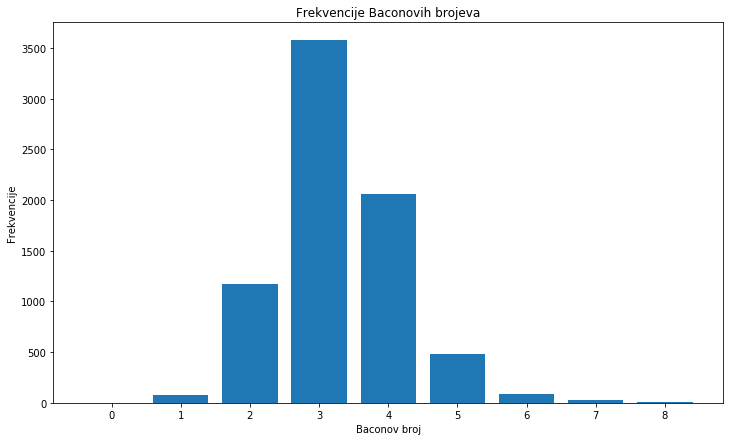

In [100]:
import numpy as np
plt.bar(bacon_frekv.keys(),bacon_frekv.values())
plt.title('Frekvencije Baconovih brojeva')
plt.xlabel('Baconov broj')
plt.ylabel('Frekvencije')
oznake=['0','1','2','3','4','5','6','7','8']
plt.xticks(np.arange(9), oznake)
plt.show()

In [101]:
suma=0
for broj,frekv in bacon_frekv.items():
    suma+=frekv*broj
prosjek=suma/(suradnje.number_of_nodes()-nedostizni)
print(f'Prosječni Baconov broj u ovom grafu je {prosjek}')

Prosječni Baconov broj u ovom grafu je 3.281024819855885


Pritom smo prosječni broj računali samo za glumce koji su povezani s Baconom.

In [102]:
print(f'{nedostizni} vrhova je nedostižno iz vrha Kevin Bacon.')

1715 vrhova je nedostižno iz vrha Kevin Bacon.


Treba uzeti u obzir da ovaj skup podataka nije potpun, odnosno ne sadrži sve hollywoodske glumce i filmove. Stoga je moguće da su ovi nedostižni glumci u stvarnosti preko nekih drugih glumaca i filmova povezani s Kevinom Baconom.

Najveći Baconov broj u ovom grafu je 8. Imamo 9 glumaca s Baconovim brojem 8. Ispišimo kako su oni povezani s Baconom. 

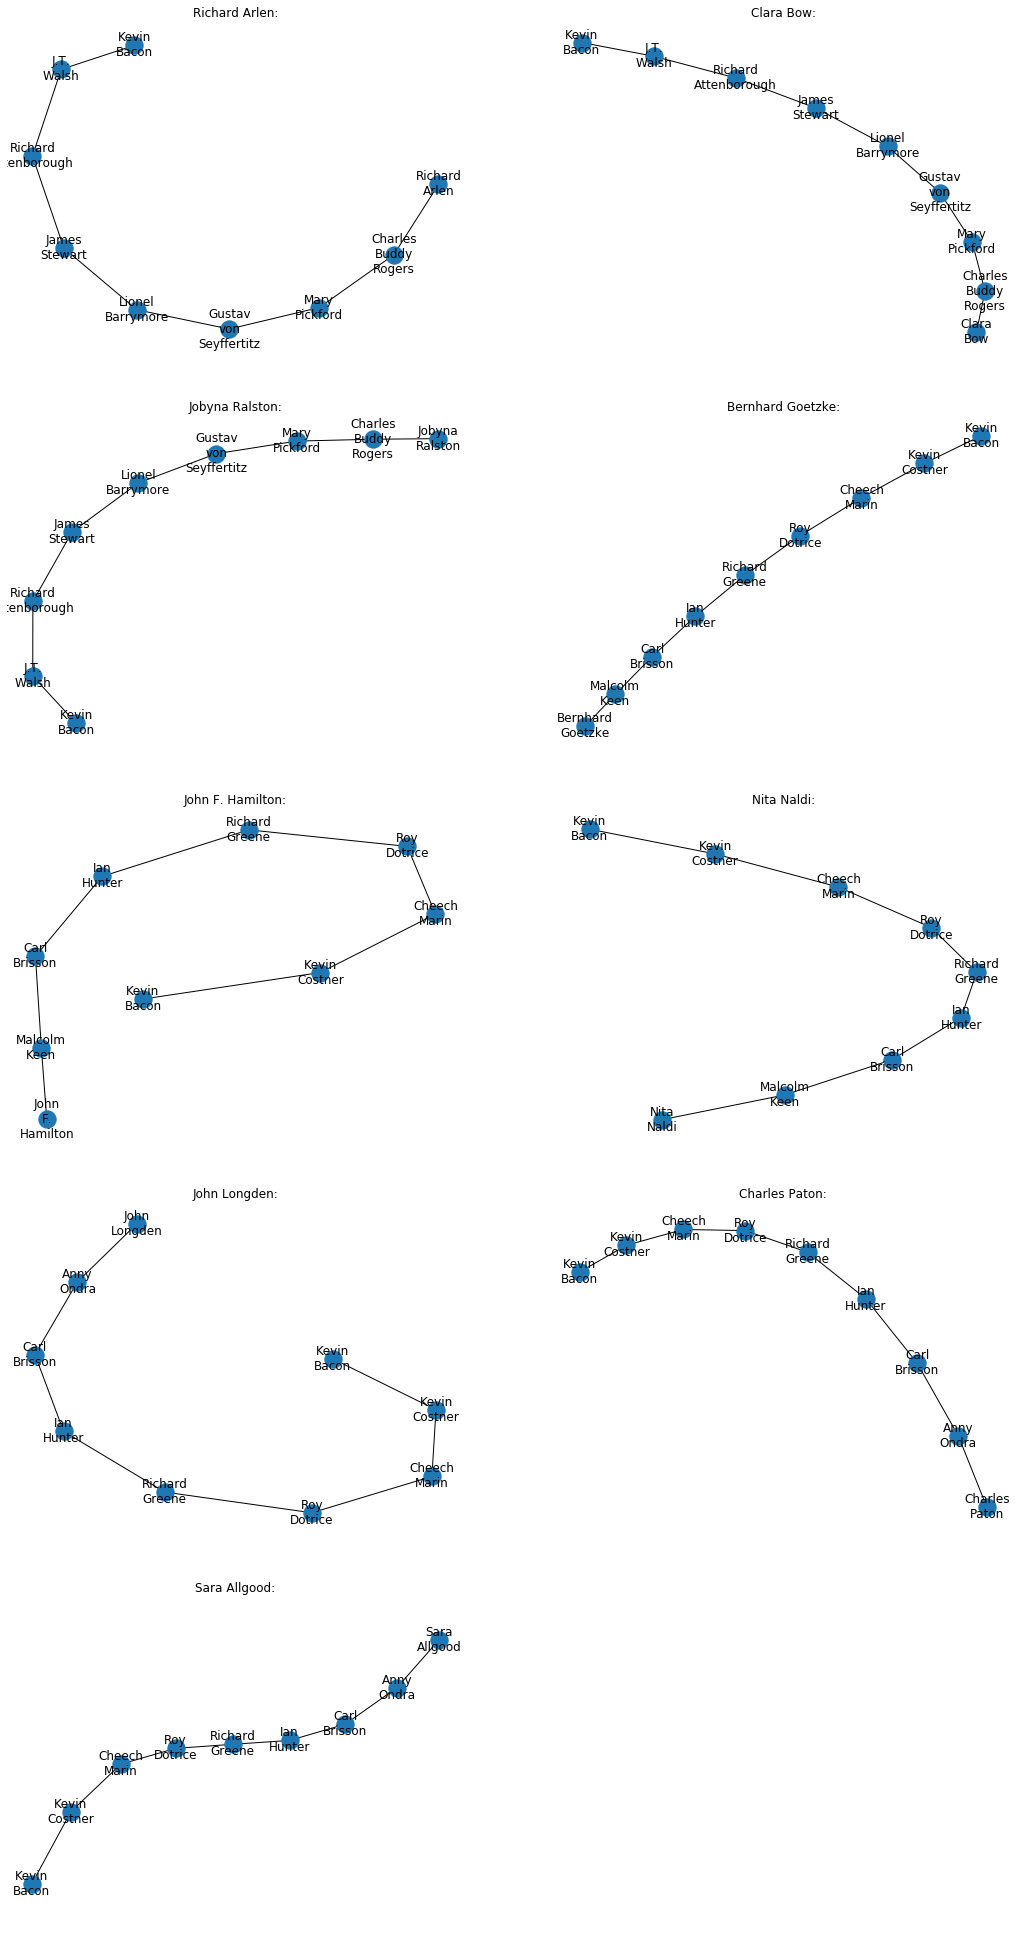

In [103]:
plt.rcParams['figure.figsize'] = [18,35]
iterator=1
for actor in bacon[8]:
    g=nx.Graph()
    put=bfs_put(suradnje,actor,actors_id['Kevin Bacon'])
    for i in range(len(put)-1):
        g.add_edge('\n'.join(id_actors[put[i]].split(' ')),'\n'.join(id_actors[put[i+1]].split(' ')))
    plt.subplot(5,2,iterator)
    plt.title(f'{id_actors[actor]}:')
    iterator+=1
    pos=nx.spring_layout(g)
    nx.draw(g,pos,with_labels=True)
plt.show()


### Igrajte se sami

Unesite ime glumca (Ime Prezime) i saznajte njegov Baconov broj ako je u bazi.

Ako postoji put do Kevina Bacona ispisat će se glumci između i filmovi koji ih povezuju.

Ime glumca: Karl Urban
Baconov broj: 5


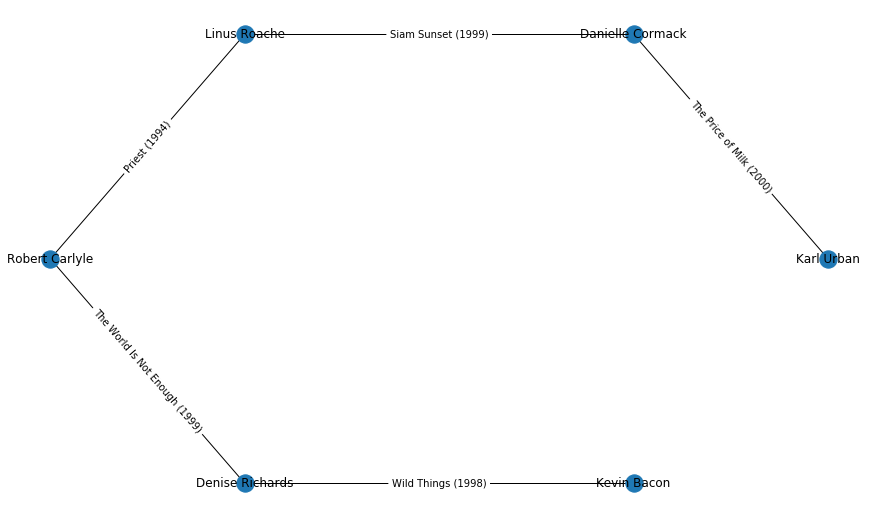

In [105]:
dostizni=set(actors_id.keys())
name=input('Ime glumca: ')
if name in dostizni:
    put=bfs_put(suradnje,actors_id[name],actors_id['Kevin Bacon'])
    b=len(put)-1
    print(f'Baconov broj: {b}')
else:
    print('Glumac nije u bazi ili u ovoj bazi ne postoji put do Kevina Bacona.')
    
def film(glumac1,glumac2):
    for film in actors_movies[glumac1]:
        if glumac2 in movies_actors[film]:
            return film

oznake={}
plt.rcParams['figure.figsize'] = [12,7]
g=nx.Graph()
for i in range(len(put)-1):
    g.add_edge(id_actors[put[i]],id_actors[put[i+1]])
    movie=id_movies[film(put[i],put[i+1])]
    if ', The ' in movie:
        movie='The '+movie.replace(', The ',' ')
    if ', A ' in movie:
        movie='A '+movie.replace(', A ',' ')
    if ', An ' in movie:
        movie='An '+movie.replace(', An ',' ')
    oznake[(id_actors[put[i]],id_actors[put[i+1]])]=movie
pos=nx.shell_layout(g)
nx.draw(g,pos,with_labels=True)
nx.draw_networkx_edge_labels(g,pos,edge_labels=oznake)
plt.show()

### Distribucija stupnjeva

Stupanj vrha je broj bridova koji izlaze iz tog vrha.

Distribucija stupnjeva je vjerojatnosna distribucija stupnjeva u cijelom grafu. To jest distribucija stupnja $P(k)$ je udio vrhova u grafu koji imaju stupanj $k$. Odnosno ako u grafu s $n$ vrhova ima $n_{k}$ vrhova stupnja k tada je $P(k)=\frac{n_{k}}{n}$.

In [85]:
def plot_deg_dist(G):
    all_degrees=np.array(nx.degree(G))[:,1]
    different_degrees=np.array(list(set(all_degrees)))
    
    max=different_degrees.max()
    min=different_degrees.min()
    l=len(all_degrees)
        
    counts=np.bincount(all_degrees)
    no_zero_counts=counts[np.nonzero(counts)]
    prob_of_degrees=no_zero_counts/l
    
    plt.loglog(different_degrees,prob_of_degrees,'ro',basex=10,basey=10)    
    plt.xlabel('k')
    plt.ylabel('pk')
    plt.title('Distribucija stupnjeva')
    plt.show()

Pogledajmo distribuciju stupnjeva našeg grafa ali u log-log skali.

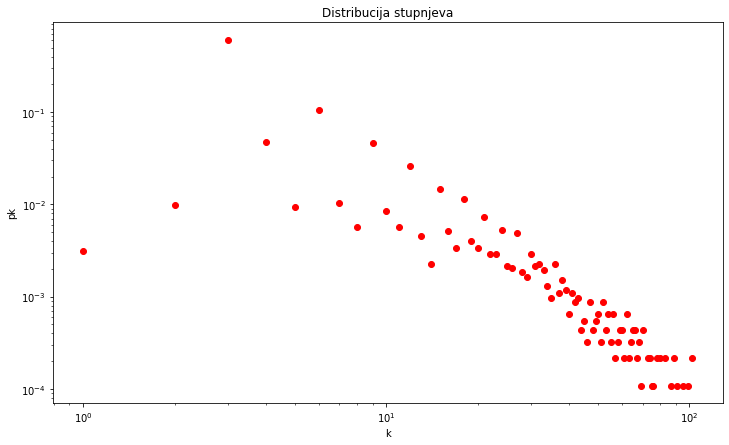

In [86]:
plot_deg_dist(suradnje)

Vidimo da u log-log skali ako zanemarimo prva dva podatka, distribucija stupnjeva je grupirana oko pravca negativnog koeficijenta smjera.

To upućuje na to da je distribucija stupnjeva oblika $P(k)=\alpha k^{-\gamma}$, ovakav oblik ovisnosti nazivamo *power-law*

(Naime ako je $\log_{10}y=-\gamma \log_{10}x+\beta$ tada je $10^{\log_{10}y}=10^{-\gamma \log_{10}x+\beta}$ pa stavljanjem $\alpha=10^{\beta}$ dobivamo $y=\alpha x^{-\gamma}$)

Grafovi gdje za velike stupnjeve $k$ vrijedi $P(k)\propto k^{-\gamma}$ zovu se **scale-free** grafovi. U nastavku ćemo promotriti jedan model *slučajnog grafa* (graf kod kojeg se vrhovi spajaju bridovima nekakvom slučajnom metodom) koji objašnjava kako dolazi do scale-free topologije i zašto se javljaju vrhovi velikog stupnja tzv. *hubovi*.  

## Barabasi-Albert model

Krećemo s grafom od $m_{0}$ čvorova koji mogu biti proizvoljno povezani.
* **Rast**: u svakom koraku dodajemo novi vrh koji povežemo s $m$ vrhova koji su već u grafu
* **Preferential attachment**: vjerojatnost da se novi vrh poveže s vrhom $i$ je $\pi(k_{i})=\frac{k_{i}}{\sum k_{i}}$ gdje je $k_{i}$ stupanj vrha i.

Pritom ne dopuštamo da se novi brid više puta poveže s istim vrhom.

Prikažimo sada prvih $20$ iteracija ovog procesa gdje krećemo od potpunog grafa s $4$ vrha i $m=2$ .U svakoj iteraciji se dodaje novi vrh koji sam označio crvenom bojom i nazvao **novi**, zelenom bojom su označeni stari vrhovi te je u svaki upisana vjerojatnost da se novi vrh spoji na njega. Veličine starih vrhova su proporcionalne tim vjerojatnostima kako bi lakše vidjeli što se događa kroz vrijeme. Novi bridovi su označeni crvenom bojom. 

In [48]:
import numpy as np

def display_graph(G):
    pos=nx.circular_layout(G)
    n=G.number_of_nodes()
    boje=['g' for k in range(n-1)]
    boje.append('r')
    g=G.subgraph(np.arange(n-1))
    node_pr=node_prob(g)
    deg_cent=nx.degree_centrality(g)
    node_size=[2500*v for v in deg_cent.values()]
    node_size.append(1000)
    nx.draw(G,pos,node_color=boje,edge_color='black',node_size=node_size)
    
    labels={}
    for k in range(n-1):
        labels[k]=f'{node_pr[k]:.2f}'
    labels[n-1]='novi'    
    nx.draw_networkx_labels(G,pos,labels)
    nx.draw_networkx_edges(G,pos,edgelist=list(G.edges(i)),edge_color='r')
    
    return
   
    
def node_prob(G):
    degrees=np.array(nx.degree(G))[:,1]
    l=2*len(G.edges())
    node_pr=degrees/l
    
    return node_pr


def add_node(G,i,m):
    node_pr=node_prob(G)
    cumulative_node_prob=[]
    it=0
    for p in node_pr:
        cumulative_node_prob.append(it+p)
        it=it+p

    G.add_node(i)
   
    num_edges_added=0
    selected_nodes=[]
    #new_edges=[]

    while(num_edges_added<m):
        node_it=0
        u=np.random.uniform(0,1)
        while(u>cumulative_node_prob[node_it]):
            node_it+=1

        selected_node=node_it
        
        if selected_node in selected_nodes:
            continue
        
        selected_nodes.append(selected_node)

        G.add_edge(i,selected_node)
        num_edges_added+=1
        #new_edges.append((i,selected_node))
    
    return 

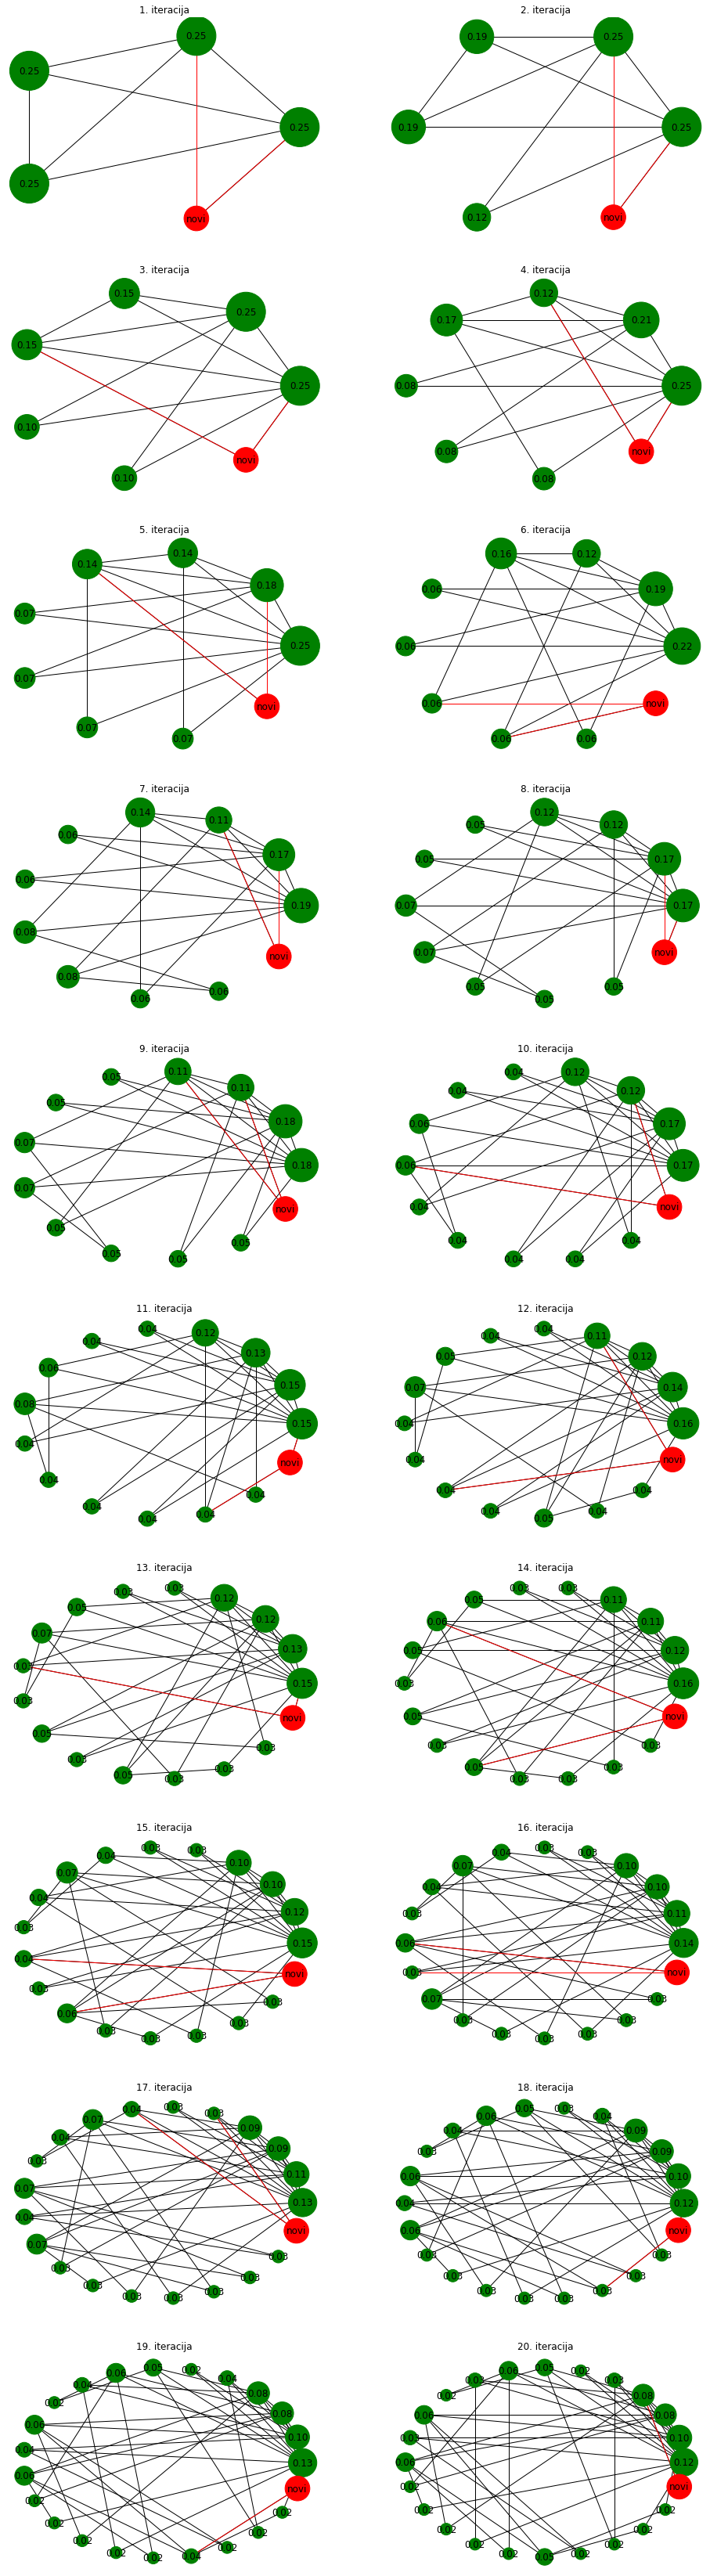

In [58]:

plt.rcParams['figure.figsize'] = [16,60]
m0=4
m=2
n=24

g=nx.complete_graph(m0)
for i in range(m0,n):
    add_node(g,i,m)
    plt.subplot(10,2,i-3)
    plt.title(f'{i-3}. iteracija')
    display_graph(g)

plt.show()
      

Vidimo da se kroz vrijeme razvijaju vrhovi koji imaju znatno veći stupanj od ostalih tzv. *hubovi* dok većina vrhova manjeg stupnja ostaju manji. Ovaj fenomen naziva se *rich-gets-richer* to jest što je vrh većeg stupnja to je veća vjerojatnost da će se novi vrh povezati na njega.

Sad se možemo pitati zašto bi ovaj model bio dobar za objasniti mrežu glumaca. Naime što je glumac glumio u više filmova to je veća vjerojatnost da ga je neki redatelj primjetio i da će ga uzeti u obzir za neku ulogu. Također poznati glumci koji imaju velik broj uloga su traženiji pa i dobivaju više uloga.

Simulirajmo sada graf s $10000$ vrhova koji kreće od potpunog grafa s $4$ vrha i u svakom koraku dodaje novi vrh s $4$ nova brida.

Za graf ćemo pratititi stupnjeve početnog vrha te vrhova koji su došli u $100.$,$1000.$ i $5000.$ koraku te ćemo prikazati distribuciju stupnjeva za krajnji graf te graf nakon $100$ i $1000$ koraka.

In [21]:
def plot_deg_dist(G,m,b):
    all_degrees=np.array(nx.degree(G))[:,1]
    different_degrees=np.array(list(set(all_degrees)))
    
    max=different_degrees.max()
    min=different_degrees.min()
    l=len(all_degrees)
        
    counts=np.bincount(all_degrees)
    no_zero_counts=counts[np.nonzero(counts)]
    prob_of_degrees=no_zero_counts/l
            
    x=np.arange(min,max+1)
    c=2*m*m
    y=c*1/x**3
    
    xn=x[y>=1/l]
    yn=y[y>=1/l]

    plt.loglog(different_degrees,prob_of_degrees,'ro',basex=10,basey=10)
    plt.plot(xn,yn,'--c')
    plt.xlabel('k')
    plt.ylabel('pk')
    plt.title(f'Distribucija stupnjeva nakon {b} koraka')
    plt.show()

In [22]:
def plot_degree_dynamics(G,t,stupnjevi_0,stupnjevi_100,stupnjevi_1000,stupnjevi_5000):
    x0=np.arange(t+1)
    x100=np.arange(100,t+1)
    x1000=np.arange(1000,t+1)
    x5000=np.arange(5000,t+1)

    x=np.arange(G.number_of_nodes())
    y=4*x**(1/2)
    
    plt.loglog(x0,stupnjevi_0,'red',basex=10,basey=10)
    plt.loglog(x100,stupnjevi_100,'blue',basex=10,basey=10)
    plt.loglog(x1000,stupnjevi_1000,'green',basex=10,basey=10)
    plt.loglog(x5000,stupnjevi_5000,'black',basex=10,basey=10)
    plt.plot(x,y,'--c')
    plt.xlabel('t')
    plt.ylabel('k(t)')
    plt.title('Stupnjevi vrhova dodanih u trenutcima 0,100,1000,5000')
    plt.show()

<h3 style="color:red">! ako želite sami pokrenuti donju čeliju imajte na umu da se izvodi par minuta</h3>

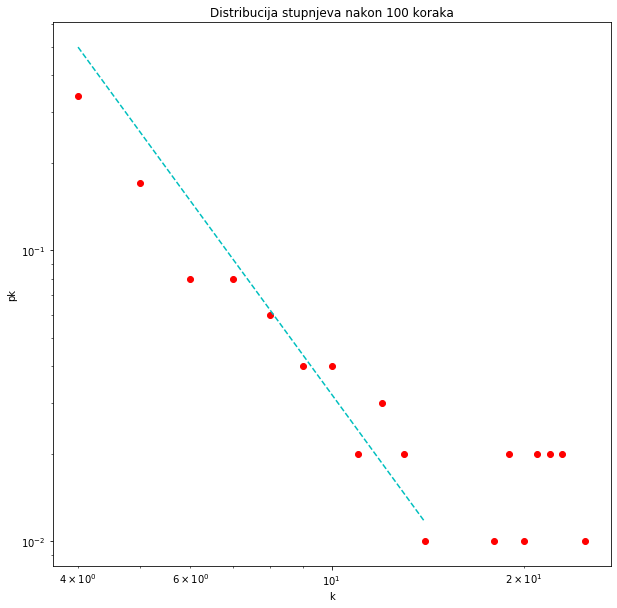

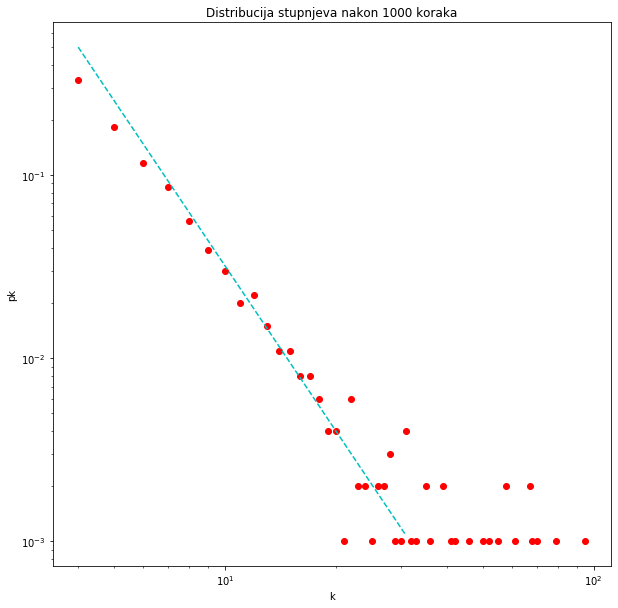

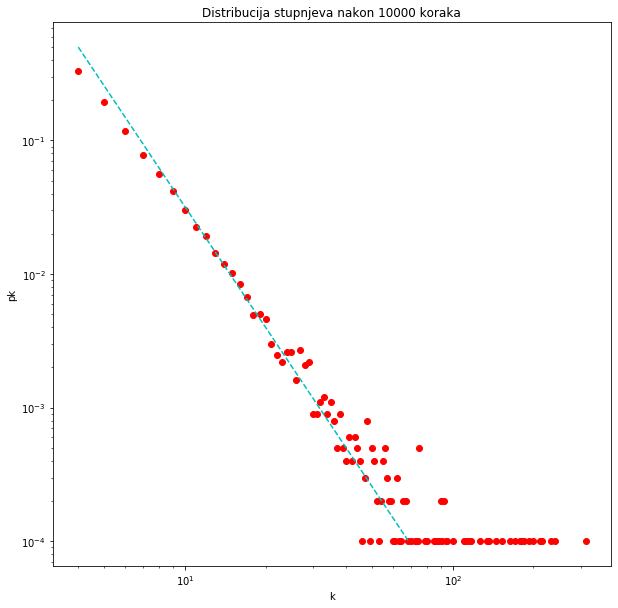

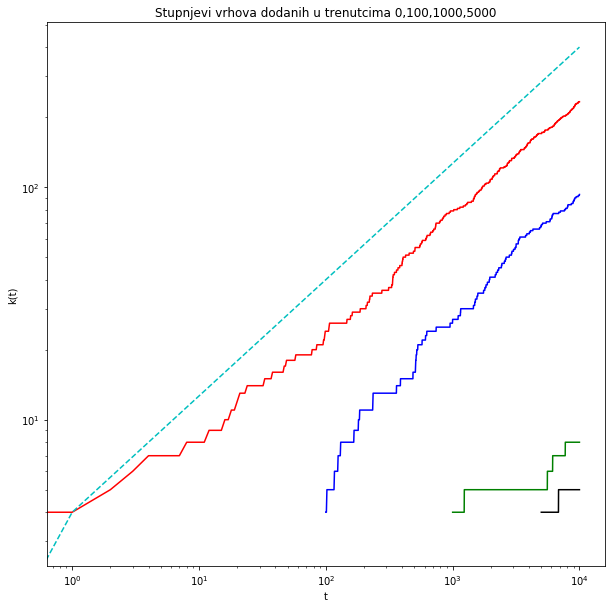

Wall time: 2min 1s


In [23]:
plt.rcParams['figure.figsize'] = [10,10]
n=10000
m0=4
m=4
G=nx.complete_graph(m0)
stupnjevi_0=[]
stupnjevi_100=[]
stupnjevi_1000=[]
stupnjevi_5000=[]
stupnjevi_0.append(m0-1)

for i in range(m0,n):
    t=i-m0+1
    add_node(G,i,m)
    if t>=100:
        stupnjevi_100.append(G.degree(103))
    if t>=1000:
        stupnjevi_1000.append(G.degree(1003))
    if t>=5000:
        stupnjevi_5000.append(G.degree(5003))
    stupnjevi_0.append(G.degree(0))
    if(i==99 or i==999 or i==9999):
        plot_deg_dist(G,m,i+1)

plot_degree_dynamics(G,t,stupnjevi_0,stupnjevi_100,stupnjevi_1000,stupnjevi_5000)

Sa zadnjeg grafa vidimo da vrhovi koji su stariji odnosno oni koji su ranije dodani imaju veći stupanj kroz vrijeme. S obzirom da smo u log-log skali opet možemo zaključiti da stupnjevi rastu poštujući isti power-law. Iscrtkani pravac je teorijska ocjena za stupanj vrha koji je u grafu prisutan od početka. Koeficjent pravca je $\frac{1}{2}$ pa vidimo da za svaki vrh $i$ vrijedi $P(k_{i})\propto k_{i}^{\frac{1}{2}}$. Odavde također vidimo da je rast sve sporiji što je i logično jer se više čvorova bori za nove bridove.

Iz grafova koji prikazuju distribuciju stupnjeva je opet jasno da poštuju power-law. To je evidentnije što imamo više vrhova u grafu. Teorijska ocjena je opet prikazana iscrtkanom linijom. Raspršenje u donjem djelu grafa se događa jer u grafu s $N$ čvorova ne možemo imati $p_{k}<\frac{1}{N}$, stoga se za velike $k$ ako postoje vrhovi tog stupnja $p_{k}$ nalazi iznad $\frac{1}{N}$. Tu se isto lijepo vidi da ovaj model dovodi do pojave *hubova*.

Ako vas zanima od kuda ove teorijske ocjene te zašto ovaj model dovodi do pojave power-law-a pogledajte [ovdje](https://barabasi.com/f/622.pdf). 

In [30]:
nx.info(G)

'Name: \nType: Graph\nNumber of nodes: 10000\nNumber of edges: 39990\nAverage degree:   7.9980'